## Transformer Encoder - Decoder

The transformer uses an encoder-decoder architecture. The encoder extracts features from an input sentence, and the decoder uses the features to produce an output sentence (translation), for example. In this case it will be used for image captioning, the task of describing the content of an image in words.

## Dataset

In this case, instead of classifying each digit, our model must generate its name (0 -> zero, 1 -> one, ...).

When dealing now with sequences in the output of variable length, we have to add 'padding' to be able to build 'batches', we will use the value 0. On the other hand, we will use a value of 1 to indicate the start of a sequence and 2 to indicate the end. 

The rest of the values will correspond to the index of each letter in the name of the number in a vocabulary that includes all possible letters (+3 to take into account the 3 extra tokens).

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 706 kB 2.6 MB/s 
     |████████████████████████████████| 5.9 MB 58.1 MB/s 
     |████████████████████████████████| 419 kB 73.0 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [ ]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_len=8):
        self.X = X 
        self.y = y 
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        img = torch.tensor(self.X[ix]).float().view(1, 28, 28)
        # add `end of sentence` -> 2
        # use 1 for `start of sentence`
        caption = torch.tensor([1] + self.y[ix] + [2]).long()
        # use 0 for pad
        caption = F.pad(caption, (0, self.max_len - len(caption)), 'constant', 0)
        return img, caption

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 1024):
        super().__init__()
        self.batch_size = batch_size
        self.vocab = 'abcdefghijklmnopqrstuvwxyz'
        self.len_vocab = len(self.vocab) + 3

    def number2caption(self, ix):
        if ix == 0: return 'cero'
        if ix == 1: return 'uno'
        if ix == 2: return 'dos'
        if ix == 3: return 'tres'
        if ix == 4: return 'cuatro'
        if ix == 5: return 'cinco'
        if ix == 6: return 'seis'
        if ix == 7: return 'siete'
        if ix == 8: return 'ocho'
        if ix == 9: return 'nueve'
        
    def caption2ixs(self, caption):
       return [self.vocab.index(c) + 3 for c in caption]

    def ixs2caption(self, ixs):
       return ('').join([self.vocab[ix - 3] for ix in ixs if ix not in [0, 1, 2]])

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"], mnist["target"].astype(np.int)
        # convert labels to words
        captions = [self.number2caption(ix) for ix in y]
        # each letter has its number (index in the vocab)
        encoded = [self.caption2ixs(caption) for caption in captions]
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., encoded[:60000], encoded[60000:]
        X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
        self.train_ds = Dataset(X_train, y_train)
        self.val_ds = Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, pin_memory=True)

In [ ]:
dm = MNISTDataModule(batch_size=64)
dm.setup()
imgs, captions = next(iter(dm.train_dataloader()))
imgs.shape, captions.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(torch.Size([64, 1, 28, 28]), torch.Size([64, 8]))

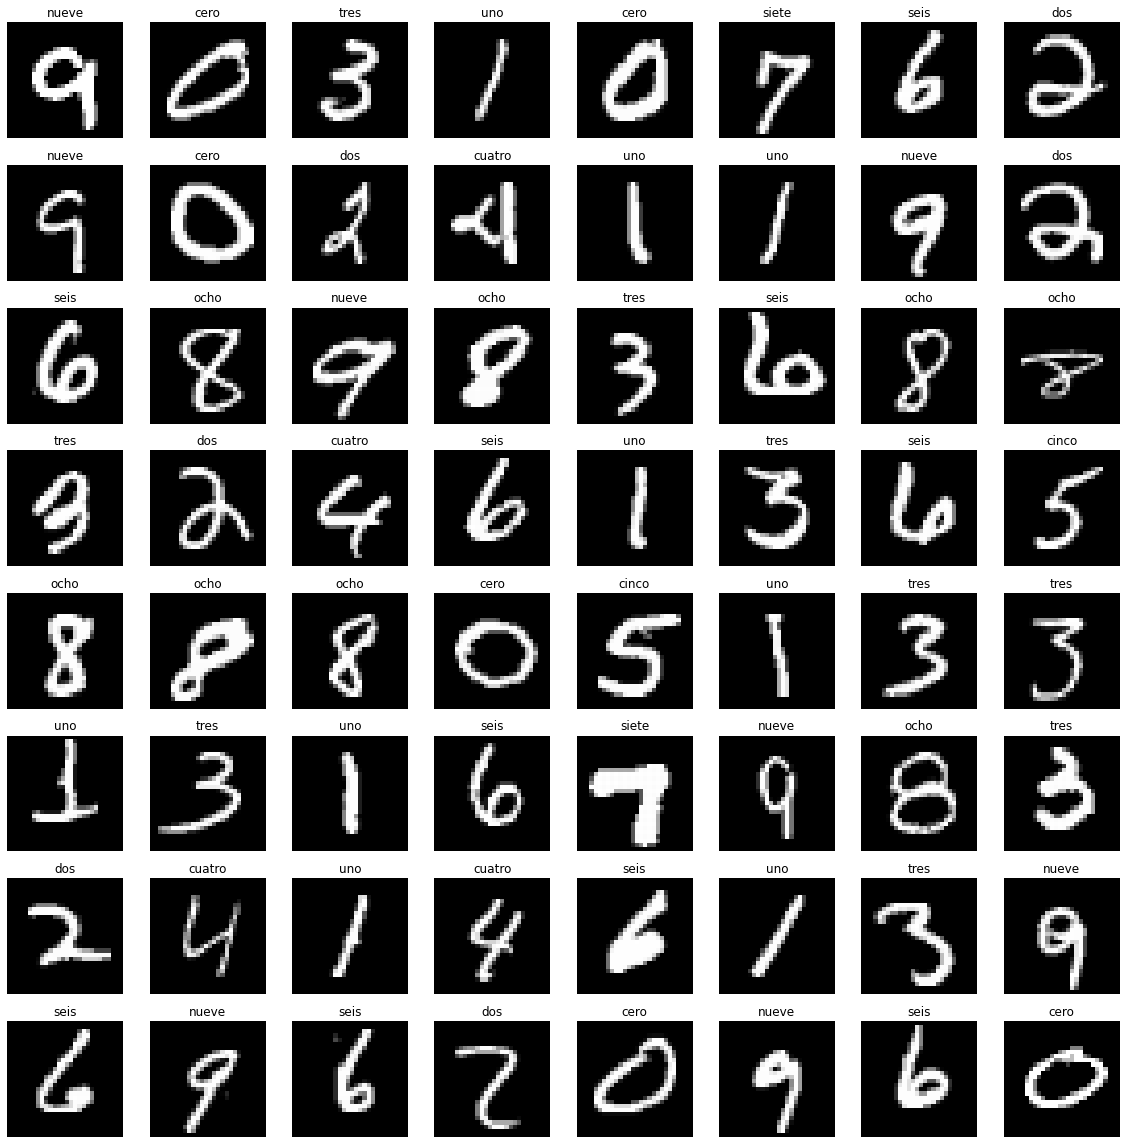

In [ ]:
r, c = 8, 8
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, caption = imgs[ix], captions[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        label = dm.ixs2caption(caption)
        ax.set_title(label)
plt.tight_layout()
plt.show()

## Model

For the model we will use the implementation of 'Transformer' that Pytorch offers us, this implementation already includes an 'encoder' and 'decoder'.

The only detail that we have to take into account is the processing of the images and the text at the input of the transformer. For images we opted for the same solution of a 'ViT' model (without the first classification token, as it is not needed in this case).

In [ ]:
import torch.nn as nn

# https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [ ]:
pe = PatchEmbedding(28, 7, 1, 100)
out = pe(imgs)
out.shape

torch.Size([64, 16, 100])

Regarding the embedding of the text, we will use the Pytorch embedding layer, the same for the positional embedding of the text in the decoder.

Finally, we will use an MLP to obtain a probability distribution over the entire vocabulary for each decoder output. We will compare these values with the ground truth to build our loss function and train the full model.

In [ ]:
import torch.nn.functional as F

class Model(pl.LightningModule):

    def __init__(self, 
                 len_vocab,
                 img_size=28, 
                 patch_size=7, 
                 in_chans=1, 
                 embed_dim=100, 
                 max_len=8, 
                 nhead=2, 
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 dim_feedforward=400,
                 dropout=0.1
                ):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches, embed_dim))
        
        self.trg_emb = nn.Embedding(len_vocab, embed_dim)
        self.trg_pos_emb = nn.Embedding(max_len, embed_dim)
        self.max_len = max_len

        self.transformer = torch.nn.Transformer(
            embed_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout
        )
        
        self.l = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, len_vocab)

    def forward(self, images, captions):
        # embed images
        embed_imgs = self.patch_embed(images)
        embed_imgs = embed_imgs + self.pos_embed  # (B, N, E)
        # embed captions
        B, trg_seq_len = captions.shape 
        trg_positions = (torch.arange(0, trg_seq_len).expand(B, trg_seq_len).to(self.device))
        embed_trg = self.trg_emb(captions) + self.trg_pos_emb(trg_positions)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_len).to(self.device)
        tgt_padding_mask = captions == 0
        # transformer
        y = self.transformer(
            embed_imgs.permute(1,0,2),  # S, B, E
            embed_trg.permute(1,0,2),  # T, B, E
            tgt_mask=trg_mask, # T, T
            tgt_key_padding_mask = tgt_padding_mask
        ).permute(1,0,2) # B, T, E
        # head
        return self.fc(self.l(y))

    def predict(self, images):
        self.eval()
        with torch.no_grad():
            images = images.to(self.device)
            B = images.shape[0]
            # start of sentence
            eos = torch.tensor([1], dtype=torch.long, device=self.device).expand(B, 1)
            trg_input = eos
            #while True:
            for _ in range(self.max_len):
                preds = self(images, trg_input)
                preds = torch.argmax(preds, axis=2)
                trg_input = torch.cat([eos, preds], 1)
                #if torch.any(captions == 2, 1).sum().item() == B or captions.shape[1] >= model.max_len:
                #    return preds
            return preds
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x, y[:,:-1])
        trg_output = y[:,1:] # target sin EOS token
        # [ Batch, seq len, num features ] --> [ Batch, num features, seq len ]
        loss = F.cross_entropy(y_hat.permute(0,2,1), trg_output) 
        acc = (torch.argmax(y_hat, axis=2) == trg_output).sum().item() / (trg_output.shape[0]*trg_output.shape[1])
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

In [ ]:
model = Model(dm.len_vocab)
out = model(imgs, captions)
out.shape

torch.Size([64, 8, 29])

## Trainig

In [ ]:
dm = MNISTDataModule()
model = Model(dm.len_vocab)
trainer = pl.Trainmer(max_epochs=10, gpus=1, precision=16, logger=None)
trainer.fit(model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and i

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Evaluation

In [ ]:
imgs, captions = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

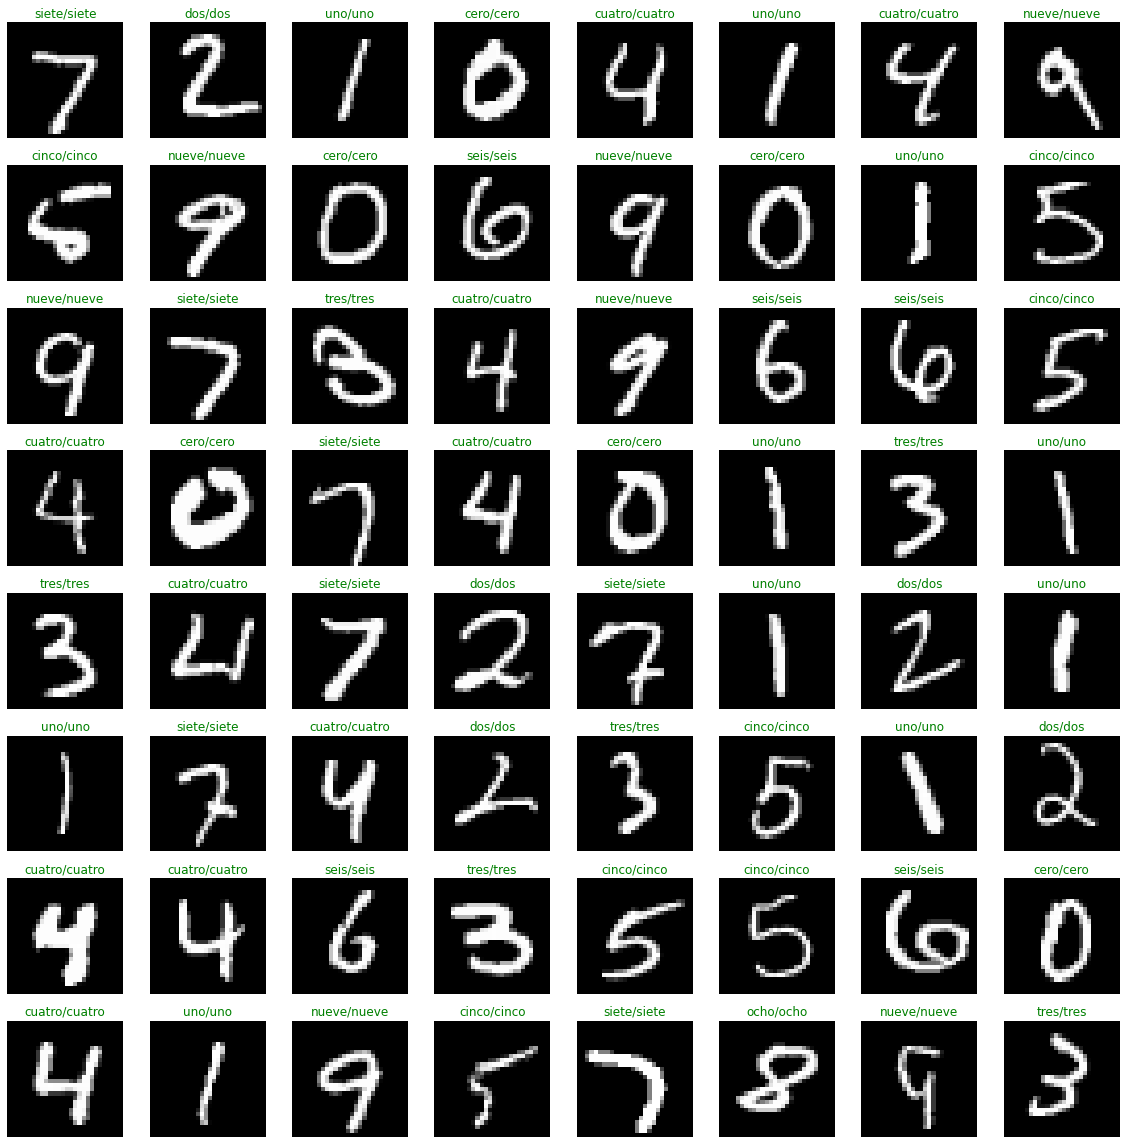

In [ ]:
r, c = 8, 8
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, caption = imgs[ix], captions[ix]
        ax.axis("off")
        ax.imshow(img.squeeze(0), cmap="gray")
        label = dm.ixs2caption(caption)
        pred = dm.ixs2caption(preds[ix])
        ax.set_title(label)
        ax.set_title(f'{label}/{pred}', color="green" if label == pred else 'red')
plt.tight_layout()
plt.show()